# C02 Emissions-Modelling Data

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import random
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression 

In [59]:
df=pd.read_csv('df.csv', index_col=False)

In [60]:
df.pop("Unnamed: 0")

0          0
1          1
2          2
3          3
4          4
        ... 
5986    7380
5987    7381
5988    7382
5989    7383
5990    7384
Name: Unnamed: 0, Length: 5991, dtype: int64

In [61]:
#converting the categorical data into dummy variables
df_dummy=pd.get_dummies(df, prefix='', prefix_sep='',columns=['Fuel Type','Transmission_Type'])

In [62]:
df_dummy.head(1)

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km),DIESEL,ETHANOL,NATURAL GAS,PREMIUM GASOLINE,REGULAR GASOLINE,Automatic,Manual
0,ACURA,ILX,COMPACT,2.0,4,AS5,9.9,6.7,8.5,196,0,0,0,1,0,1,0


In [63]:
#to avoid the duplication of data, dropping one unique column for each categorical feature.
df_dummy.drop(['REGULAR GASOLINE','Manual'],inplace=True,axis=1)

## Linear Regression Model

In [64]:
#defining the X and y variable
X = df_dummy[['DIESEL','ETHANOL','NATURAL GAS','PREMIUM GASOLINE','Engine Size(L)','Cylinders','Automatic']]
y = df_dummy["CO2 Emissions(g/km)"]

In [65]:
#splitting the X and y dataset
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

In [66]:
#to avoid bias in the data outcome, we are standardizing the data by scaling it
from sklearn.preprocessing import StandardScaler

In [67]:
scaler = StandardScaler()

In [68]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [69]:
reg_all=LinearRegression()
reg_all.fit(scaled_X_train,y_train)

LinearRegression()

In [70]:
print(X_train.shape, y_train.shape)
print(scaled_X_test.shape, y_test.shape)

(4193, 7) (4193,)
(1798, 7) (1798,)


In [71]:
y_pred=reg_all.predict(scaled_X_test)
y_pred

array([205.39409838, 262.1195004 , 215.92134634, ..., 301.81418803,
       354.45042784, 209.41787993])

In [72]:
print('Accuracy of linear regression on test set: {:.2f}'.format(reg_all.score(scaled_X_test, y_test)))

Accuracy of linear regression on test set: 0.75


In [73]:
#finding the residuals
test_res = y_test - y_pred
type(test_res)

pandas.core.series.Series

In [74]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [75]:
#Mean Squared Error, Root Mean Squared Error
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)

In [76]:
MAE,RMSE

(22.99259787072235, 30.178428293529244)

## Cross-validation:

In [77]:
#Cross-validation used to estimate the skill of a machine learning model on unseen data
#results in less-bias
from sklearn.model_selection import cross_val_score, KFold

In [78]:
kf=KFold(n_splits=5,shuffle=True,random_state=42)
reg=LinearRegression()

In [79]:
cv_results=cross_val_score(reg,X,y,cv=kf)
print(cv_results)

[0.75589225 0.72442665 0.74155752 0.74935762 0.7511444 ]


In [80]:
print(np.mean(cv_results),np.std(cv_results))

0.7444756873832603 0.011037414028931054


In [81]:
print(np.quantile(cv_results,[0.025,0.975]))

[0.72613974 0.75541747]


## Ridge Regression

In [82]:
from sklearn.linear_model import Ridge

In [83]:
#ridge regression model with hyperparameter tuning
ridge_model = Ridge(alpha=0.1)

In [84]:
ridge_model.fit(X_train,y_train)

Ridge(alpha=0.1)

In [85]:
test_predictions = ridge_model.predict(X_test)

In [86]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [87]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [88]:
MAE,RMSE

(22.992510776338424, 30.17836228754734)

In [89]:
print('Accuracy of ridge regression on test set: {:.2f}'.format(ridge_model.score(X_test, y_test)))

Accuracy of ridge regression on test set: 0.75


In [90]:
from sklearn.linear_model import RidgeCV

In [91]:
#penalty strength parameter as alpha
ridge_cv_model = RidgeCV(alphas=(0.1, 1.0, 10.0,20.0),scoring='neg_mean_absolute_error')

In [92]:
#k-fold cross validation fit to the training dataset
ridge_cv_model.fit(X_train,y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. , 20. ]),
        scoring='neg_mean_absolute_error')

In [93]:
#optimal alpha
ridge_cv_model.alpha_

10.0

In [94]:
test_predictions = ridge_cv_model.predict(X_test)

In [95]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [96]:
MAE,RMSE

(22.98529428849865, 30.173288337874546)

In [97]:
ridge_cv_model.coef_

array([ 9.41002256, -7.04529021,  0.        ,  3.93739401, 26.06805448,
        8.78259913,  0.17411884])

In [98]:
print('Accuracy of ridge regression on test set: {:.2f}'.format(ridge_cv_model.score(X_test, y_test)))

Accuracy of ridge regression on test set: 0.75


## Lasso Regression

In [99]:
from sklearn.linear_model import LassoCV

In [100]:
lasso_cv_model = LassoCV(eps=0.1,n_alphas=10,cv=5)

In [101]:
lasso_cv_model.fit(X_train,y_train)

LassoCV(cv=5, eps=0.1, n_alphas=10)

In [102]:
lasso_cv_model.alpha_

8.969859393948726

In [103]:
test_predictions = lasso_cv_model.predict(X_test)

In [104]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [105]:
MAE,RMSE

(23.302243923594848, 31.30641740608961)

In [106]:
lasso_cv_model.coef_

array([ 0.        , -0.        ,  0.        ,  0.        , 13.38574599,
       14.87839714,  0.        ])

In [107]:
print('Accuracy of lasso regression on test set: {:.2f}'.format(lasso_cv_model.score(X_test, y_test)))

Accuracy of lasso regression on test set: 0.73


## Elastic Net Regression

In [108]:
from sklearn.linear_model import ElasticNetCV

In [109]:
#improve the regularization by combining lasso and ridge regression
#minimize the RSS(residual sum of squares) and the absolute and squared value terms(absolute for lasso and square for ridge)
elastic_model = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1],tol=0.01)

In [110]:
elastic_model.fit(X_train,y_train)

ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], tol=0.01)

In [111]:
elastic_model.l1_ratio_

1.0

In [112]:
test_predictions = elastic_model.predict(X_test)

In [113]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [114]:
MAE,RMSE

(22.976596119057856, 30.16707494117302)

In [115]:
# Training Set Performance
train_predictions = elastic_model.predict(X_train)
MAE = mean_absolute_error(y_train,train_predictions)
MAE

22.7934041861518

In [116]:
elastic_model.coef_

array([ 6.56075569, -5.98954917,  0.        ,  3.80760836, 26.80905803,
        8.24491728,  0.        ])

In [117]:
print('Accuracy of elestic regression on test set: {:.2f}'.format(elastic_model.score(X_test, y_test)))

Accuracy of elestic regression on test set: 0.75


## KNN Regression

In [118]:
from sklearn.neighbors import KNeighborsRegressor

Text(0.5, 1.0, 'ELBOW PLOT')

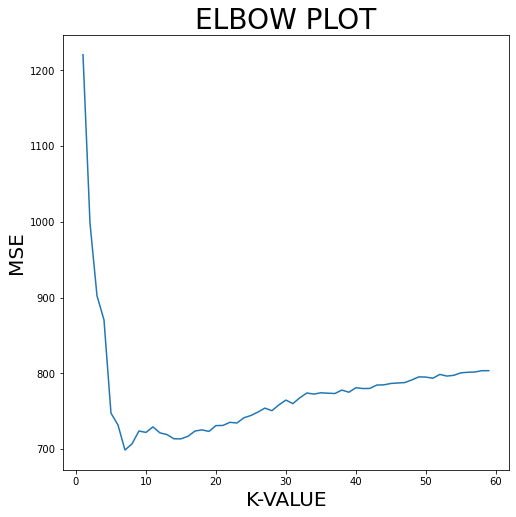

In [119]:
#Elbow plot to determine the optimal value of K that yields lowest MSE
fig,ax=plt.subplots(figsize=(8,8))
k_list=np.arange(1,60,1)
knn_dict={} # To store k and mse pairs
for i in k_list:
#Knn Model Creation
    knn=KNeighborsRegressor(n_neighbors=int(i))
    model_knn=knn.fit(X_train,y_train)
    y_knn_pred=model_knn.predict(X_test)
#Storing MSE 
    mse=mean_squared_error(y_test,y_knn_pred)
    knn_dict[i]=mse
#Plotting the results
ax.plot(knn_dict.keys(),knn_dict.values())
ax.set_xlabel('K-VALUE', fontsize=20)
ax.set_ylabel('MSE' ,fontsize=20)
ax.set_title('ELBOW PLOT' ,fontsize=28)

In [120]:
knn=KNeighborsRegressor(n_neighbors=7)

In [121]:
model_knn=knn.fit(X_train,y_train)
test_predictions=model_knn.predict(X_test)

In [122]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [123]:
MAE,RMSE

(19.53448275862069, 26.436245294391956)

In [124]:
print('Accuracy of knn regressor on test set: {:.2f}'.format(model_knn.score(X_test, y_test)))

Accuracy of knn regressor on test set: 0.81


## Support Vector Regression

In [125]:
#create a hypothetical hyperplane that maximizes the margin
#choose linear kernel
from sklearn.svm import SVR

In [126]:
base_model = SVR()

In [127]:
base_model.fit(scaled_X_train,y_train)

SVR()

In [128]:
base_preds = base_model.predict(scaled_X_test)

In [129]:
mean_absolute_error(y_test,base_preds)

23.42771761198186

In [130]:
np.sqrt(mean_squared_error(y_test,base_preds))

32.10741245024187

In [131]:
param_grid = {'C':[10, 100,200],
             'kernel':['linear'],
              'degree':[2,3,4],
              'gamma':[1,0.1,0.01],
              'epsilon':[0.1,0.5,1]}

In [132]:
from sklearn.model_selection import GridSearchCV

In [133]:
svr = SVR()
grid_model = GridSearchCV(estimator=svr,param_grid=param_grid,scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=2)

In [134]:
grid_model.fit(scaled_X_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END C=10, degree=2, epsilon=0.1, gamma=1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [10, 100, 200], 'degree': [2, 3, 4],
                         'epsilon': [0.1, 0.5, 1], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['linear']},
             scoring='neg_mean_squared_error', verbose=2)

In [135]:
grid_model.best_estimator_

SVR(C=100, degree=2, epsilon=0.5, gamma=1, kernel='linear')

In [136]:
svm=SVR(C=100,degree=2,epsilon=0.5,kernel='linear')
svm_model=svm.fit(scaled_X_train,y_train)
result=svm.predict(scaled_X_test)

In [137]:
print('Accuracy of SVM regression on test set: {:.2f}'.format(svm_model.score(scaled_X_test, y_test)))

Accuracy of SVM regression on test set: 0.75


In [138]:
MAE = mean_absolute_error(y_test,result)
MSE = mean_squared_error(y_test,result)
RMSE = np.sqrt(MSE)

In [139]:
MAE,RMSE

(22.670419890094117, 30.218486080237692)

## Regression Tree

In [140]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 42)

In [141]:
model=regressor.fit(X_train,y_train)

In [142]:
model.score(X_test, y_test)

0.8293812478108182

In [143]:
y_test_pred = model.predict(X_test)

In [144]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_test_pred)

18.49124792728084

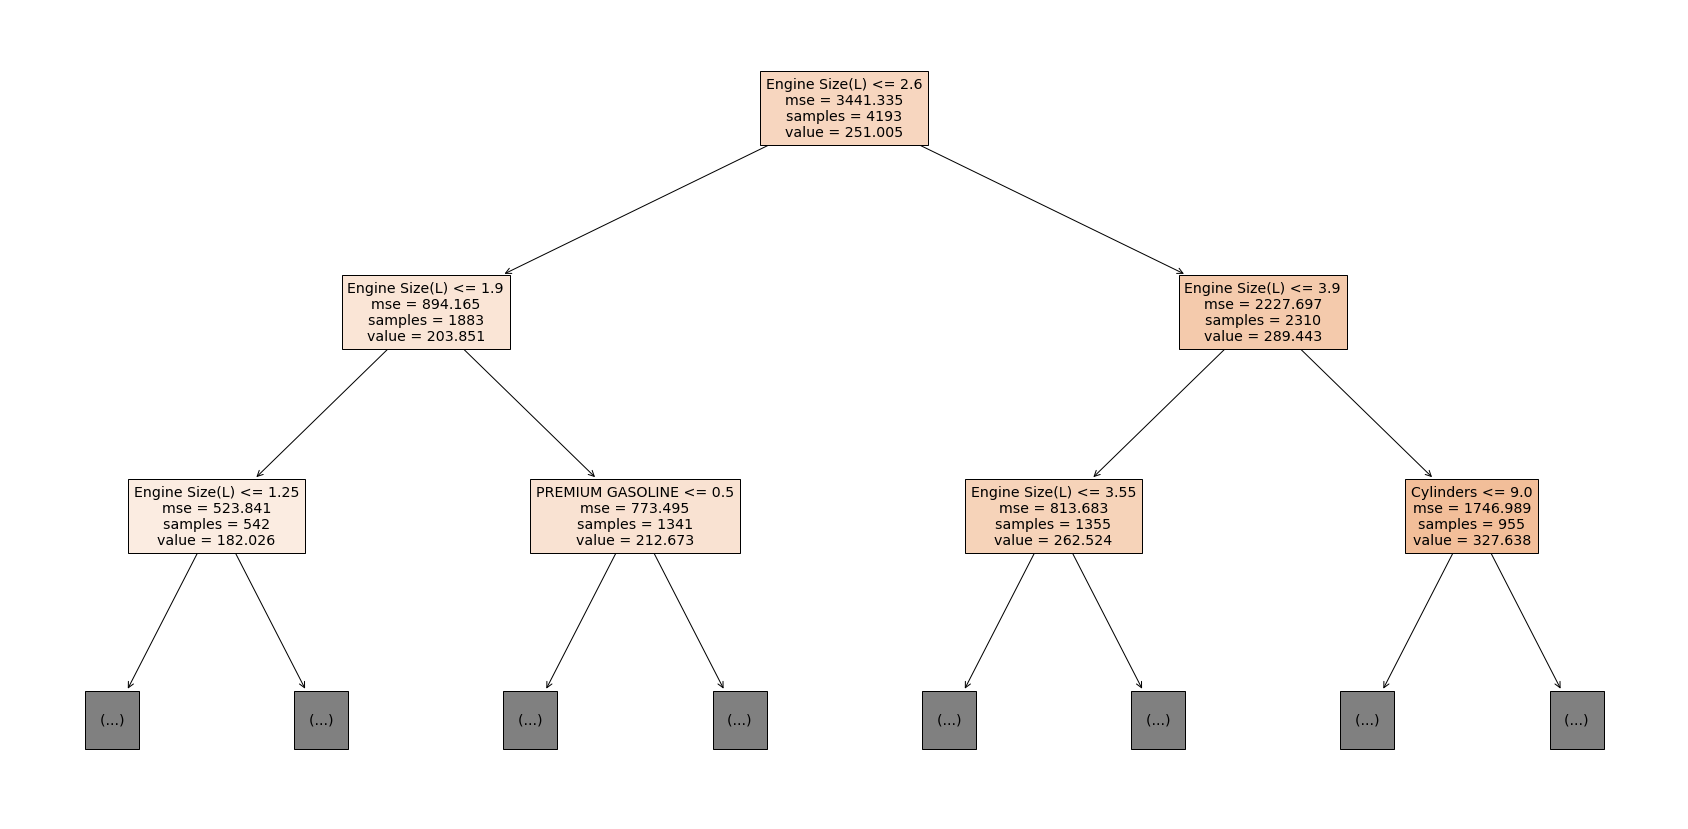

In [145]:
plt.figure(figsize = (30,15))
from sklearn import tree
tree.plot_tree(model, 
               feature_names = list(X_train.columns), 
               filled = True,
               max_depth = 2);

In [146]:
importance = model.feature_importances_
importance

array([4.36439393e-04, 3.22768412e-03, 0.00000000e+00, 1.61663767e-02,
       9.35024844e-01, 3.72502044e-02, 7.89445160e-03])

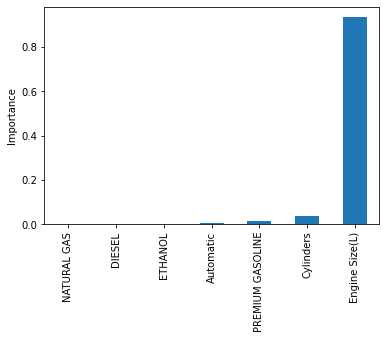

In [147]:
feature_importance = pd.Series(importance, index = X_train.columns)
feature_importance.sort_values().plot(kind = 'bar')
plt.ylabel('Importance');

The most important feature is Engine Size(L) for this model.

In [148]:
model.score(X_train, y_train)

0.8220720697447578

In [149]:
model.score(X_test, y_test)

0.8293812478108182

No pruning required as the model score for the train and testing set is same. This means there is no overfitting or underfitting of the data on the decision tree regression model.


In [150]:
tree_param = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

In [151]:
grid_model = GridSearchCV(estimator=regressor,param_grid=tree_param,scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=2)

In [152]:
model=grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ........................................max_depth=4; total time=   0.0s
[CV] END ........................................max_depth=4; total time=   0.0s
[CV] END ........................................max_depth=4; total time=   0.0s
[CV] END ........................................max_depth=4; total time=   0.0s
[CV] END ........................................max_depth=4; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=6; total time=   0.0s
[CV] END .......................................

In [153]:
y_test_pred = grid_model.predict(X_test)

In [154]:
grid_model.best_estimator_

DecisionTreeRegressor(max_depth=12, random_state=42)

In [155]:
regressor = DecisionTreeRegressor(random_state = 42,max_depth=12)

In [156]:
model2=regressor.fit(X_train,y_train)

In [157]:
model2pred=model2.predict(X_test)

In [158]:
model2.score(X_test, y_test)

0.8293812478108182

In [159]:
mean_absolute_error(y_test, y_test_pred)

18.49124792728084

## GRADIENT BOOSTING

In [160]:
from sklearn.ensemble import GradientBoostingRegressor

In [161]:
help(GradientBoostingRegressor)

Help on class GradientBoostingRegressor in module sklearn.ensemble._gb:

class GradientBoostingRegressor(sklearn.base.RegressorMixin, BaseGradientBoosting)
 |  GradientBoostingRegressor(*, loss='ls', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
 |  
 |  Gradient Boosting for regression.
 |  
 |  GB builds an additive model in a forward stage-wise fashion;
 |  it allows for the optimization of arbitrary differentiable loss functions.
 |  In each stage a regression tree is fit on the negative gradient of the
 |  given loss function.
 |  
 |  Read more in the :ref:`User Guide <gradient_boosting>`.
 |  
 |  Parameters
 |  ----------
 |  loss 

In [162]:
from sklearn.model_selection import GridSearchCV

In [163]:
param_grid = {"n_estimators":[1,5,10,20,40,100,200,300],'max_depth':[3,4,5,6,8]}

In [164]:
gb_model = GradientBoostingRegressor()

In [165]:
grid_gb_model = GridSearchCV(gb_model,param_grid)

In [166]:
grid_gb_model.fit(X_train,y_train)

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 8],
                         'n_estimators': [1, 5, 10, 20, 40, 100, 200, 300]})

In [167]:
grid_gb_model.best_params_

{'max_depth': 6, 'n_estimators': 200}

In [169]:
predictions = grid_gb_model.predict(X_test)

In [170]:
predictions

array([202.84107158, 269.90282763, 218.52545466, ..., 316.39325077,
       333.17512656, 217.91858161])

In [171]:
grid_gb_model.best_estimator_.feature_importances_

array([2.70121936e-04, 2.86365186e-03, 0.00000000e+00, 1.55998730e-02,
       9.36991942e-01, 3.72184148e-02, 7.05599655e-03])

In [177]:
feat_import = grid_gb_model.best_estimator_.feature_importances_
feat_import

array([2.70121936e-04, 2.86365186e-03, 0.00000000e+00, 1.55998730e-02,
       9.36991942e-01, 3.72184148e-02, 7.05599655e-03])

In [178]:
imp_feats = pd.DataFrame(index=X.columns,data=feat_import,columns=['Importance'])

In [180]:
imp_feats.sort_values(by='Importance')

,Importance
NATURAL GAS,0.000000
DIESEL,0.000270
ETHANOL,0.002864
Automatic,0.007056
PREMIUM GASOLINE,0.015600
Cylinders,0.037218
Engine Size(L),0.936992


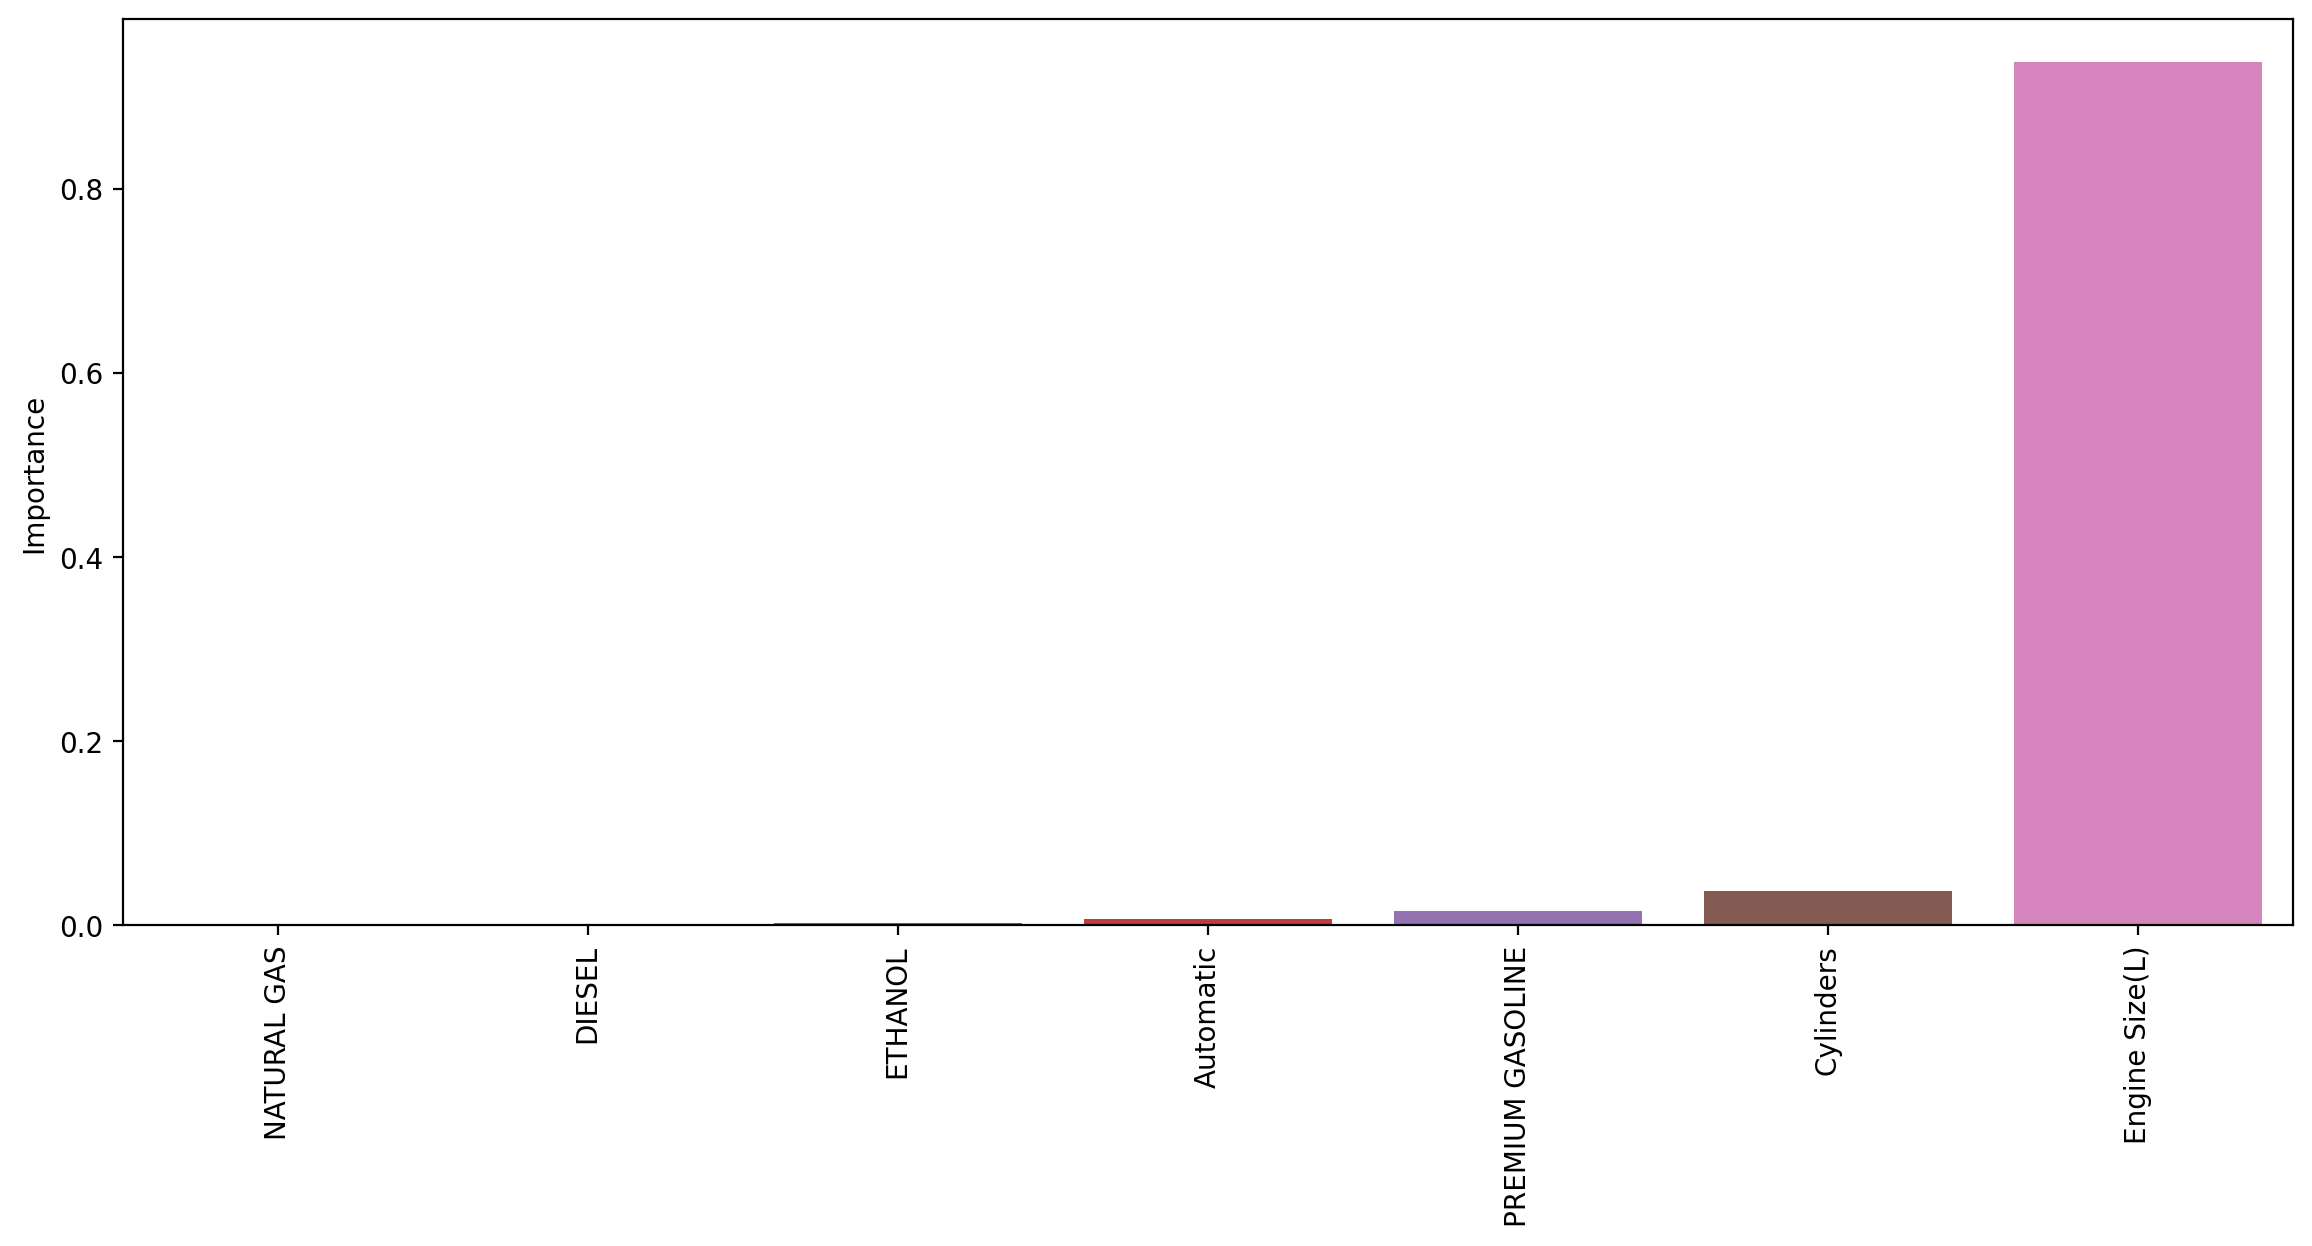

In [181]:
plt.figure(figsize=(14,6),dpi=200)
sns.barplot(data=imp_feats.sort_values(by='Importance'),x=imp_feats.sort_values(by='Importance').index,y='Importance')

plt.xticks(rotation=90);

In [182]:
grid_gb_model.score(X_test, y_test)

0.8285603584050926

In [183]:
gb_model.fit(X_train,y_train)

GradientBoostingRegressor()

In [184]:
gb_model.score(X_test, y_test)

0.8109837997002249

In [185]:
print('Accuracy of GB cross validation regression on test set: {:.2f}'.format(grid_gb_model.score(X_test, y_test)))

Accuracy of GB cross validation regression on test set: 0.83


## Random Forest Regression

In [186]:
from sklearn.ensemble import RandomForestRegressor

In [187]:
rfr_model = RandomForestRegressor().fit(X_train, y_train)

In [188]:
y_pred = rfr_model.predict(X_test)

In [189]:
print('Accuracy of RF regression on test set: {:.2f}'.format(rfr_model.score(X_test, y_test)))

Accuracy of RF regression on test set: 0.83


In [190]:
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)

In [191]:
MAE,RMSE

(18.564726926703276, 25.074814105025187)

## Random Search with Cross Validation

In [192]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [193]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   0.9s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   0.9s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   1.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   1.0s
[CV] END bootstrap=True, max_depth=60, m

In [1078]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': False}

In [1079]:
y_pred = rf_random.predict(X_test)

In [1080]:
print('Accuracy of RF cross validation regression on test set: {:.2f}'.format(rf_random.score(X_test, y_test)))

Accuracy of RF cross validation regression on test set: 0.83


## SUMMARY

From all these models, random forest regression, gradient boosting and regression tree produced the best score of 0.83 which shows that these models are best for predicting the carbon dioxide emissions from vehicles.